In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

from gym_microrts import microrts_ai
from gym_microrts.envs.vec_env import MicroRTSGridModeVecEnv

In [2]:
rows_letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
action_types = ["NOOP", "move", "harvest", "return", "produce", "attack"]
location_parameters = ["north", "east", "south", "west"]
unit_types = ["resource", "base", "barracks", "worker", "light", "heavy", "ranged"]

def action_mask_to_string(action_mask_tiles, row, col):
    resulting_strings = []

    unit = f"{rows_letters[row]}{col}"

    # NOOP
    if action_mask_tiles[0] == 1:
        resulting_strings.append(f"({unit}, NOOP)")

    # move
    if action_mask_tiles[1] == 1:
        for i, param in zip(action_mask_tiles[6:10], location_parameters):
            if i == 1:
                resulting_strings.append(f"({unit}, move, {param})")

    # harvest
    if action_mask_tiles[2] == 1:
        for i, param in zip(action_mask_tiles[10:14], location_parameters):
            if i == 1:
                resulting_strings.append(f"({unit}, harvest, {param})")

    # return
    if action_mask_tiles[3] == 1:
        for i, param in zip(action_mask_tiles[14:18], location_parameters):
            if i == 1:
                resulting_strings.append(f"({unit}, return, {param})")

    # produce
    if action_mask_tiles[4] == 1:
        for i, param in zip(action_mask_tiles[18:22], location_parameters):
            if i == 1:
                for j, param2 in zip(action_mask_tiles[22:29], unit_types):
                    if j == 1:
                        resulting_strings.append(f"({unit}, produce, {param}, {param2})")

    return resulting_strings

In [3]:
def decode_action_mask(action_mask, map_size):

    action_mask = action_mask.reshape(-1, action_mask.shape[-1])
    action_mask = action_mask.reshape(map_size, map_size, -1)
    
    valid_actions = []
    for row in range(map_size):
        for col in range(map_size):
            am_tile = action_mask[row][col]
            valid_action = action_mask_to_string(am_tile, row, col)
            if len(valid_action) > 0:
                valid_actions.extend(valid_action)

    prompt_valid_actions = "\n".join(valid_actions)
    return prompt_valid_actions

In [4]:
owners = ["NEUTRAL", "PLAYER", "ENEMY"]
obs_unit_types = ["NO_UNIT"] + unit_types

def create_positions(map_size):
    positions = np.array([
        [
            [f"{rows_letters[j]}{i}"] for j in range(map_size)
        ] for i in range(map_size)
    ])
    return positions

def extract_observation_features(features):
    feat_hit_points = features[0:5]
    hit_points = np.argmax(feat_hit_points)

    feat_resources = features[5:10]
    resources = np.argmax(feat_resources)
    resources = None if resources == 0 else f"resources: {resources}"

    feat_owner = features[10:13]
    owner = np.argmax(feat_owner)
    str_owner = owners[owner]

    feat_unit_types = features[13:21]
    unit_type = np.argmax(feat_unit_types)
    str_unit_type = obs_unit_types[unit_type]

    feat_action_type = features[21:27]
    action_type = np.argmax(feat_action_type)
    str_action_type = action_types[action_type]

    obs_str = (
        str_unit_type, 
        f"hp:{hit_points}", 
        resources, 
        str_owner, 
        str_action_type
    )

    return obs_str

In [5]:
def decode_observation(observation, map_size=8):
    positions = create_positions(map_size)
    decoded_observation = np.apply_along_axis(extract_observation_features, 2, observation[0])
    decoded_observation = np.concatenate((positions, decoded_observation), axis=-1)
    obs_with_units = decoded_observation[decoded_observation[:, :, 1] != 'NO_UNIT']
    prompt_str = np.apply_along_axis(lambda x: "("+", ".join(x)+")", 1, obs_with_units)
    prompt_str = "\n".join(prompt_str)

    return prompt_str

# LLAMA

In [6]:
def get_system_prompt():
    prompt = """"
You are a professional MicroRTS player.
You know all the dependencies between units, buildings, attack system and the rules of the game.
The primary goal is to defeat the opponent by either destroying their bases or eliminating all their units.

## RULES

Gridworld Board Description:

The game is played on a grid-based map, with a size of 4x4 grid.
Each cell represents a specific location. 
Rows are labeled A, B, C, and D, while columns are numbered 0, 1, 2, and 3.
Example: A0 represents the top-left cell, and D3 represents the bottom-right cell.

Game Elements:

(A) Resources:
- Mineral Resources: Used to create new units and buildings, can be harvested by workers. Once harvested, the worker needs to bring the mineral to a base.

(B) Buildings:
- Base: Accumulates resources and trains workers. Bases are buildings.
- Barrack: Creates new attack units. Barracks are buildings.

(C) Units:
- Worker: Can harvest minerals and construct buildings. Is able to move one tile at a timestep, can only harvest adjacent tiles, can only construct buildings in adjacent tiles.
- Light: Attack unit with low power but fast melee capabilities. Is able to move one tile at a timestep, can attack enemies in adjacent tiles.
- Heavy: Attack unit with high power but slow melee capabilities. Is able to move one tile at a timestep, can attack enemies in adjacent tiles.
- Ranged: Attack unit with long-range capabilities. Is able to move one tile at a timestep, can attack enemies that are within a 3 tile radius of the current position.

## ACTION

Based on the current observation of the game state, Units and Buildings from both sides.
You can only issue micro actions to the units, meaning that before a certain worker is able to harverst resources at A1, it needs first to be in an adjacent tile, for example A2 or B1. 
Also, you can only issue actions for the current timestep.
Each unit can execute only one action, which means that in the response dictionary, you can only include one action per unit.
You don't need to issue actions to all units, but you can. 
You must respect the set of valid actions.
Use your best judgement and strategy to select the actions. Provide the next set of micro immediate actions. 

You should only respond in the format as described below:

RESPONSE FORMAT:
(tile, action, direction, produce_unit_type)

Example:

(A0, move, north)
(A1, harvest, north)
(A2, return, north)

"""
    return prompt

In [9]:
def fill_prompt1(observation, valid_actions):
    prompt = f"""
You are a professional MicroRTS player.
You know all the dependencies between units, buildings, attack system and the rules of the game.
The primary goal is to defeat the opponent by either destroying their bases or eliminating all their units.

## RULES

Gridworld Board Description:

The game is played on a grid-based map, with a size of 4x4 grid.
Each cell represents a specific location. 
Rows are labeled A, B, C, and D, while columns are numbered 0, 1, 2, and 3.
Example: A0 represents the top-left cell, and D3 represents the bottom-right cell.

Game Elements:

(A) Resources:
- Mineral Resources: Used to create new units and buildings, can be harvested by workers. Once harvested, the worker needs to bring the mineral to a base.

(B) Buildings:
- Base: Accumulates resources and trains workers. Bases are buildings.
- Barrack: Creates new attack units. Barracks are buildings.

(C) Units:
- Worker: Can harvest minerals and construct buildings. Is able to move one tile at a timestep, can only harvest adjacent tiles, can only construct buildings in adjacent tiles.
- Light: Attack unit with low power but fast melee capabilities. Is able to move one tile at a timestep, can attack enemies in adjacent tiles.
- Heavy: Attack unit with high power but slow melee capabilities. Is able to move one tile at a timestep, can attack enemies in adjacent tiles.
- Ranged: Attack unit with long-range capabilities. Is able to move one tile at a timestep, can attack enemies that are within a 3 tile radius of the current position.

## OBSERVATION

Obervation:
(position, unit_type, hp, resources, owner, action_type)
[
{observation}
]

Set of valid actions:
(position, action_type, direction, production_type)
[
{valid_actions}
]

## ACTION

Based on the current observation of the game state, Units and Buildings from both sides.
You can only issue micro actions to the units, meaning that before a certain worker is able to harverst resources at A1, it needs first to be in an adjacent tile, for example A2 or B1. 
Also, you can only issue actions for the current timestep.
Each unit can execute only one action, which means that in the response dictionary, you can only include one action per unit.
You don't need to issue actions to all units, but you can. 
You must respect the set of valid actions.
Use your best judgement and strategy to select the actions. Provide the next set of micro immediate actions. 

You should only respond in the format as described below:

RESPONSE FORMAT:
(tile, action, direction, produce_unit_type)

Select the actions in the set of valid actions and provide the response in the format above.
"""
    return prompt

In [10]:
def fill_prompt2(observation, valid_actions):
    prompt = f"""
You are a professional MicroRTS player.
You know all the dependencies between units, buildings, attack system and the rules of the game.
The primary goal is to defeat the opponent by either destroying their bases or eliminating all their units.

Obervation:
(position, unit_type, hp, resources, owner, action_type)
[
{observation}
]


Based on the current observation of the game state, evaluate what is the best action to execute.
Select the desired actions in the set of valid actions below:

Set of valid actions:
(position, action_type, direction, production_type)
[
{valid_actions}
]

RESPONSE FORMAT:
(tile, action, direction, produce_unit_type)

Select the actions in the set of valid actions and provide the response in the format above.
"""
    return prompt

# Game Lifecycle

In [11]:
def string_to_action(response, map_size):
    actions = np.zeros((map_size, map_size, 7))

    for value in response:
        try:
            s_action = value.strip("()").split(", ")

            unit = s_action[0]
            actiontype_choice = s_action[1]
            actiontype_param = action_types.index(actiontype_choice)

            location_choice = s_action[2]
            location_param = location_parameters.index(location_choice)

            if len(s_action) > 3:
                unit_type_choice = s_action[3] 
                unit_types_param = unit_types.index(unit_type_choice)
            else:
                unit_types_param = 0

            row = rows_letters.index(unit[0])
            col = int(unit[1])

            action = [
                actiontype_param,
                location_param,
                location_param,
                location_param,
                location_param,
                unit_types_param,
                0  # attack_target parameter TBD
            ]

            actions[row][col] = action
        except:
            print(f"Invalid action: {value}")
            continue
        print(s_action)
        

    return actions

In [12]:
# ollama serve

from ollama import Client
client = Client(host='http://localhost:11434')

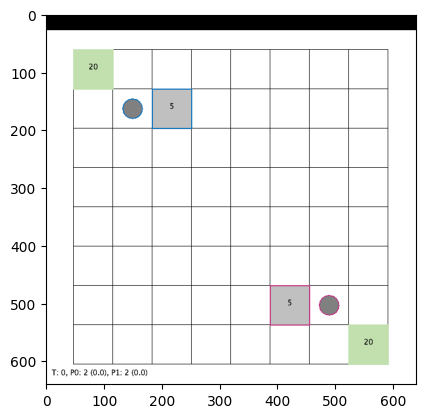

In [13]:
map_size = 8
no_action = np.zeros((1, map_size*map_size, 78))

envs = MicroRTSGridModeVecEnv(
    num_selfplay_envs=0,
    num_bot_envs=1,
    max_steps=2000,
    render_theme=2,
    ai2s=[microrts_ai.naiveMCTSAI for _ in range(1)],
    # ai2s=[microrts_ai.coacAI for _ in range(1)],
    # map_paths=["maps/4x4/base4x4.xml"],
    map_paths=["maps/8x8/basesWorkers8x8.xml"],
    reward_weight=np.array([10.0, 1.0, 1.0, 0.2, 1.0, 4.0]),
)
response = envs.reset()
action_mask = envs.get_action_mask()
img = envs.render(mode='rgb_array')
plt.imshow(img)

In [14]:
system_prompt = get_system_prompt()
images = []
action = no_action
for i in range(2000):

    if i%50 == 0 and i != 0:
        print("-"*80)
        print(f"{i = }")

        # Prepare prompt
        action_mask = envs.get_action_mask()
        prompt_valid_actions = decode_action_mask(action_mask, map_size)
        prompt_obs = decode_observation(response[0], map_size=map_size)
        prompt = fill_prompt2(prompt_obs, prompt_valid_actions)
        print(f"    prompt_valid_actions = ")
        print(prompt_valid_actions)

        # Send prompt to Llama
        llama_response = client.chat(model='mistral', messages=[
            {'role': 'system', 'content': system_prompt},
            {'role': 'user', 'content': prompt}
        ])

        # Process response
        content = llama_response['message']['content']
        found_actions = re.findall(r'\((.*?)\)', content)
        print(f"    found_actions = ")
        action = string_to_action(found_actions, map_size)

        #import pdb; pdb.set_trace()
        
    response = envs.step(action)

    img = envs.render(mode='rgb_array')
    images.append(img)    

    if response[2][0]:
        print("done")
        break


--------------------------------------------------------------------------------
i = 50
    prompt_valid_actions = 
(B1, NOOP)
(B1, move, north)
(B1, move, south)
(B1, move, west)
(B1, produce, north, barracks)
(B1, produce, south, barracks)
(B1, produce, west, barracks)
(B2, NOOP)
(B2, produce, north, worker)
(B2, produce, east, worker)
(B2, produce, south, worker)
    found_actions = 
Invalid action: C1, NOOP
Invalid action: Keep the base safe and intact
['B1', 'produce', 'north', 'barracks']
Invalid action: Build a new Barrack closer to the enemy, expanding our production capabilities
['G6', 'move', 'east']
Invalid action: Move the enemy worker away from its resource, preventing them from harvesting it
['F7', 'move', 'south']
Invalid action: Move the enemy worker towards your base with the intention of engaging it in combat or disrupting their building plans
['B1', 'produce', 'north', 'barracks']
['G6', 'move', 'east']
['F7', 'move', 'south']
----------------------------------------

In [15]:
from gus.utils import save_video
save_video(images, path='experiment_llm3.mp4')

Video saved


In [1]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0pp", device_map="auto")

/Users/gustavo/miniconda3/envs/gymllm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("bigscience/T0pp")
model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0pp")

inputs = tokenizer.encode("Is this review positive or negative? Review: this is the best cast iron skillet you will ever buy", return_tensors="pt")
outputs = model.generate(inputs)
print(tokenizer.decode(outputs[0]))